### Breast analysis of publicly available data from here:
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE191127 <br>
https://www.nature.com/articles/s41523-022-00428-8

In [1]:
#where the raw data is stored   
fold0 = "../../breast/tables/"

In [ ]:
#loading the required libraries
library(tibble)
library(calibrate)
library(genefilter)
library(parallel)
library(stats4)
library(BiocGenerics)
library(IRanges)
library(DESeq2)
library(MASS)
library(S4Vectors)
library(dplyr)
library(tidyr)
library(reshape2)
library(readxl)
library(writexl)
library(GSVA)
library(biomaRt)
library(msigdb)
library(msigdbr)
library(enrichR)
library(fgsea)
library(Biobase)
library(RColorBrewer)
library(gplots)
library(ggplot2)
library(ComplexHeatmap)
library(pheatmap)
library(stringr)

Caricamento del pacchetto richiesto: grid

ComplexHeatmap version 2.20.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


Warning message:
"il pacchetto 'calibrate' è stato creato con R versione 4.4.3"
Caricamento del pacchetto richiesto: MASS


Caricamento pacchetto: 'genefilter'


Il seguente oggetto è mascherato da 'package:MASS':

    area


Il seguente oggetto è mascherato 

# DEA

In [3]:
#loading the metadata from table1 of the paper
table1 = read_excel("../../breast/table1.xlsx")

In [4]:
table1  %>%  head

StudyID,Histology,Regimen,NRI,RCB,Grade,T-stage,N-stage,Subtype,Recurrence,Recurrence location,Vital status,Exome seq,RNA seq,DNA_pre_TP,DNA_post_TP,RNA_pre_TP,RNA_post_TP
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
97,IDC,6× ddAC,0.33,2,NA,2,−,LUM,0,NA,A,1,1,70,80,70,75
188,IDC,"1×AC, 1×CD",0,2,3,2,−,TN,1,"Lung, brain",D,1,0,80,80,NA,NA
2046,IDC,6× ddAC,0,3,3,2,+,TN,1,Liver,D,1,1,70,70,50,70
2271,IDC,6× ddAC,0.33,2,3,2,+,TN,1,"Thorax, lymph, contralateral mamma, skin",D,1,1,80,55,90,55
2472,IDC,"4× ddAC, 2× CTC + PSCT",0.33,3,2,2,+,TN,1,"Multiple lymph nodes, lung, liver",D,0,1,NA,NA,80,70
2492,IDC,6× ddAC,0.33,3,2,2,+,TN,1,Brain,D,1,1,90,50,60,50


In [5]:
#read the raw counts
raw = read.table(gzfile(paste0(fold0,"GSE191127_readcounts_prepost.txt.gz"),"rt"),
                 header=TRUE, sep = "\t",quote = "\"", fill = TRUE, comment.char = "", 
                 stringsAsFactors = FALSE)

In [6]:
raw  %>% head(2)

,ensembl_gene_id,X3597_1_97_B_AACGTGAT,X3597_2_97_S_AAACATCG,X3597_3_2046_B_ATGCCTAA,X3597_4_2046_S_AGTGGTCA,X3597_5_2271_B_ACCACTGT,X3597_6_2271_S_ACATTGGC,X3597_7_2472_B_CAGATCTG,X3597_8_2472_S_CATCAAGT,X3597_9_2492_B_CGCTGATC,⋯,X3597_37_3130_B_CCGAAGTA,X3597_38_3130_S_CCGTGAGA,X3597_39_3161_B_CCTCCTGA,X3597_40_3161_S_CGAACTTA,gene_biotype,chromosome_name,start_position,end_position,external_gene_id,description
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<chr>
1,ENSG00000000457,421,869,347,463,1286,463,616,561,573,⋯,686,880,399,1722,protein_coding,1,169818772,169863408,SCYL3,SCY1-like 3 (S. cerevisiae) [Source:HGNC Symbol;Acc:19285]
2,ENSG00000000460,213,267,223,630,1080,431,780,630,172,⋯,143,156,114,254,protein_coding,1,169631245,169823221,C1orf112,chromosome 1 open reading frame 112 [Source:HGNC Symbol;Acc:25565]


In [7]:
metadata = raw %>% dplyr::select("ensembl_gene_id","gene_biotype","chromosome_name","start_position","end_position","external_gene_id","description")

In [8]:
counts = raw %>% dplyr::select(ensembl_gene_id, matches("_B_|_S_")) %>% column_to_rownames("ensembl_gene_id")

In [9]:
counts  %>% head

,X3597_1_97_B_AACGTGAT,X3597_2_97_S_AAACATCG,X3597_3_2046_B_ATGCCTAA,X3597_4_2046_S_AGTGGTCA,X3597_5_2271_B_ACCACTGT,X3597_6_2271_S_ACATTGGC,X3597_7_2472_B_CAGATCTG,X3597_8_2472_S_CATCAAGT,X3597_9_2492_B_CGCTGATC,X3597_10_2492_S_ACAAGCTA,⋯,X3597_31_3036_B_CAAGACTA,X3597_32_3036_S_CAATGGAA,X3597_33_3065_B_CACTTCGA,X3597_34_3065_S_CAGCGTTA,X3597_35_3067_B_CATACCAA,X3597_36_3067_S_CCAGTTCA,X3597_37_3130_B_CCGAAGTA,X3597_38_3130_S_CCGTGAGA,X3597_39_3161_B_CCTCCTGA,X3597_40_3161_S_CGAACTTA
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000457,421,869,347,463,1286,463,616,561,573,377,⋯,418,612,270,491,460,307,686,880,399,1722
ENSG00000000460,213,267,223,630,1080,431,780,630,172,225,⋯,109,201,150,93,164,88,143,156,114,254
ENSG00000000938,171,359,224,156,88,168,169,176,314,278,⋯,140,315,195,122,107,192,74,106,68,94
ENSG00000000971,732,849,408,176,748,2618,446,986,645,1398,⋯,2445,5015,984,3681,680,2111,1498,3038,1675,1926
ENSG00000001460,178,231,73,147,96,168,200,298,135,239,⋯,127,196,133,199,107,73,111,159,143,321
ENSG00000001461,1331,1927,310,506,769,898,957,1447,823,1045,⋯,976,1416,985,1247,603,381,688,1088,572,2075


In [10]:
matrix <- as.matrix(counts)
head(matrix)

,X3597_1_97_B_AACGTGAT,X3597_2_97_S_AAACATCG,X3597_3_2046_B_ATGCCTAA,X3597_4_2046_S_AGTGGTCA,X3597_5_2271_B_ACCACTGT,X3597_6_2271_S_ACATTGGC,X3597_7_2472_B_CAGATCTG,X3597_8_2472_S_CATCAAGT,X3597_9_2492_B_CGCTGATC,X3597_10_2492_S_ACAAGCTA,⋯,X3597_31_3036_B_CAAGACTA,X3597_32_3036_S_CAATGGAA,X3597_33_3065_B_CACTTCGA,X3597_34_3065_S_CAGCGTTA,X3597_35_3067_B_CATACCAA,X3597_36_3067_S_CCAGTTCA,X3597_37_3130_B_CCGAAGTA,X3597_38_3130_S_CCGTGAGA,X3597_39_3161_B_CCTCCTGA,X3597_40_3161_S_CGAACTTA
ENSG00000000457,421,869,347,463,1286,463,616,561,573,377,⋯,418,612,270,491,460,307,686,880,399,1722
ENSG00000000460,213,267,223,630,1080,431,780,630,172,225,⋯,109,201,150,93,164,88,143,156,114,254
ENSG00000000938,171,359,224,156,88,168,169,176,314,278,⋯,140,315,195,122,107,192,74,106,68,94
ENSG00000000971,732,849,408,176,748,2618,446,986,645,1398,⋯,2445,5015,984,3681,680,2111,1498,3038,1675,1926
ENSG00000001460,178,231,73,147,96,168,200,298,135,239,⋯,127,196,133,199,107,73,111,159,143,321
ENSG00000001461,1331,1927,310,506,769,898,957,1447,823,1045,⋯,976,1416,985,1247,603,381,688,1088,572,2075


In [11]:
# create coldata while cleaning a bit the column names
cond <- cbind(c(colnames(matrix)),
        c(sapply(strsplit(colnames(matrix), "_"),`[`, 3)),
        c(sapply(strsplit(colnames(matrix), "_"),`[`, 4)))
colnames(cond) = c('Name', 'pat','resp')
row.names(cond) = colnames(matrix)
colData = as.data.frame(cond)

In [12]:
colData = colData  %>% mutate(resp2 = ifelse(resp=="B","pre","post"))

In [13]:
colnames(table1)[colnames(table1) == "StudyID"] <- "pat"

In [14]:
colData  %>%  head

,Name,pat,resp,resp2
,<chr>,<chr>,<chr>,<chr>
X3597_1_97_B_AACGTGAT,X3597_1_97_B_AACGTGAT,97,B,pre
X3597_2_97_S_AAACATCG,X3597_2_97_S_AAACATCG,97,S,post
X3597_3_2046_B_ATGCCTAA,X3597_3_2046_B_ATGCCTAA,2046,B,pre
X3597_4_2046_S_AGTGGTCA,X3597_4_2046_S_AGTGGTCA,2046,S,post
X3597_5_2271_B_ACCACTGT,X3597_5_2271_B_ACCACTGT,2271,B,pre
X3597_6_2271_S_ACATTGGC,X3597_6_2271_S_ACATTGGC,2271,S,post


In [15]:
table1 = table1  %>% mutate(pat = as.character(pat))

In [16]:
colData = left_join(colData,table1,by="pat")

In [17]:
head(colData)

,Name,pat,resp,resp2,Histology,Regimen,NRI,RCB,Grade,T-stage,⋯,Subtype,Recurrence,Recurrence location,Vital status,Exome seq,RNA seq,DNA_pre_TP,DNA_post_TP,RNA_pre_TP,RNA_post_TP
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
1,X3597_1_97_B_AACGTGAT,97,B,pre,IDC,6× ddAC,0.33,2,NA,2,⋯,LUM,0,NA,A,1,1,70,80,70,75
2,X3597_2_97_S_AAACATCG,97,S,post,IDC,6× ddAC,0.33,2,NA,2,⋯,LUM,0,NA,A,1,1,70,80,70,75
3,X3597_3_2046_B_ATGCCTAA,2046,B,pre,IDC,6× ddAC,0,3,3,2,⋯,TN,1,Liver,D,1,1,70,70,50,70
4,X3597_4_2046_S_AGTGGTCA,2046,S,post,IDC,6× ddAC,0,3,3,2,⋯,TN,1,Liver,D,1,1,70,70,50,70
5,X3597_5_2271_B_ACCACTGT,2271,B,pre,IDC,6× ddAC,0.33,2,3,2,⋯,TN,1,"Thorax, lymph, contralateral mamma, skin",D,1,1,80,55,90,55
6,X3597_6_2271_S_ACATTGGC,2271,S,post,IDC,6× ddAC,0.33,2,3,2,⋯,TN,1,"Thorax, lymph, contralateral mamma, skin",D,1,1,80,55,90,55


In [20]:
# create DESeq object and in the design formula we include the patient as covariate and the response as the main factor
dds <- DESeqDataSetFromMatrix(countData=matrix, 
                              colData=colData, 
                              design=~resp2 + pat)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"


In [21]:
dds <- DESeq(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [26]:
fold="../../breast/"

In [22]:
#checking at the results of the comparison between pre and post treatment
res <- results(dds,c('resp2',"post", "pre"))
res <- res[order(res$padj), ]

In [23]:
resdata <- merge(as.data.frame(res), as.data.frame(counts(dds, normalized=TRUE)), by="row.names", sort=FALSE)

In [30]:
metadata %>%  head

,ensembl_gene_id,gene_biotype,chromosome_name,start_position,end_position,external_gene_id,description
,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>
1,ENSG00000000457,protein_coding,1,169818772,169863408,SCYL3,SCY1-like 3 (S. cerevisiae) [Source:HGNC Symbol;Acc:19285]
2,ENSG00000000460,protein_coding,1,169631245,169823221,C1orf112,chromosome 1 open reading frame 112 [Source:HGNC Symbol;Acc:25565]
3,ENSG00000000938,protein_coding,1,27938575,27961788,FGR,feline Gardner-Rasheed sarcoma viral oncogene homolog [Source:HGNC Symbol;Acc:3697]
4,ENSG00000000971,protein_coding,1,196621008,196716634,CFH,complement factor H [Source:HGNC Symbol;Acc:4883]
5,ENSG00000001460,protein_coding,1,24683489,24743424,STPG1,sperm-tail PG-rich repeat containing 1 [Source:HGNC Symbol;Acc:28070]
6,ENSG00000001461,protein_coding,1,24742284,24799466,NIPAL3,NIPA-like domain containing 3 [Source:HGNC Symbol;Acc:25233]


In [32]:
#renaming the first column to Gene for both the results and the metadata
names(resdata)[1] <- "Gene"
metadata = metadata  %>%  rename("Gene" = ensembl_gene_id)

In [33]:
resdata = resdata  %>% left_join(metadata, by = "Gene")

In [34]:
resdata  %>%  head

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,X3597_1_97_B_AACGTGAT,X3597_2_97_S_AAACATCG,X3597_3_2046_B_ATGCCTAA,⋯,X3597_37_3130_B_CCGAAGTA,X3597_38_3130_S_CCGTGAGA,X3597_39_3161_B_CCTCCTGA,X3597_40_3161_S_CGAACTTA,gene_biotype,chromosome_name,start_position,end_position,external_gene_id,description
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<chr>
1,ENSG00000164949,894.20841,2.3117461,0.19149848,12.071877,1.487038e-33,3.223006e-29,90.46093,574.38966,148.97396,⋯,326.77607,1303.398839,434.40655,1019.51460,protein_coding,8,95261481,95274578,GEM,GTP binding protein overexpressed in skeletal muscle [Source:HGNC Symbol;Acc:4234]
2,ENSG00000187955,6083.70690,2.3808647,0.22043253,10.800877,3.409310e-27,3.694669e-23,534.98400,2415.72734,77.14723,⋯,6159.90344,23450.162070,8017.12804,13701.97234,protein_coding,8,121072019,121384275,COL14A1,"collagen, type XIV, alpha 1 [Source:HGNC Symbol;Acc:2191]"
3,ENSG00000102189,790.03510,0.6522355,0.06188234,10.539930,5.654070e-26,4.084877e-22,584.59160,918.42513,474.85451,⋯,684.95056,1436.450606,740.81831,1067.17484,protein_coding,12,93164413,93323107,EEA1,early endosome antigen 1 [Source:HGNC Symbol;Acc:3185]
4,ENSG00000240184,524.56882,1.3468676,0.13492937,9.982019,1.827099e-23,9.900135e-20,209.13011,425.55692,85.12798,⋯,594.24404,1511.874856,694.27476,914.52394,protein_coding,5,140855580,140892542,PCDHGC3,"protocadherin gamma subfamily C, 3 [Source:HGNC Symbol;Acc:8716]"
5,ENSG00000232810,63.32949,-2.0890107,0.21000301,-9.947527,2.585269e-23,1.120663e-19,47.66221,29.91613,111.73047,⋯,43.02745,6.779708,25.85753,3.45364,protein_coding,6,31543344,31546113,TNF,tumor necrosis factor [Source:HGNC Symbol;Acc:11892]
6,ENSG00000017427,1368.64534,2.0028824,0.20303158,9.864881,5.910437e-23,2.135047e-19,179.94916,1020.88787,89.11835,⋯,823.33616,2673.747292,562.40134,2274.56747,protein_coding,12,102789645,102874423,IGF1,insulin-like growth factor 1 (somatomedin C) [Source:HGNC Symbol;Acc:5464]


In [ ]:
#plotting the histogram of p-values
png(paste0(fold,"Hist-PValues.png"))
hist(res$pvalue, breaks=50, col="grey")
dev.off()

pdf 
  2

In [ ]:
maplot <- function (res, thresh=0.05, labelsig=TRUE, textcx=1, ...) {
  with(res, plot(baseMean, log2FoldChange, pch=20, cex=.5, log="x", ...))
  with(subset(res, padj<thresh), points(baseMean, log2FoldChange, col="red", pch=20, cex=1.5))
  if (labelsig) {
    require(calibrate)
    with(subset(res, padj<thresh), textxy(baseMean, log2FoldChange, labs=external_gene_id, cex=textcx, col=2))
  }
}

png(paste0(fold,"diffexpr-maplot.png"), 1500, 1500, pointsize=20)
maplot(resdata, main="MA Plot", ylim=c(-8,15))
dev.off()

pdf 
  2

In [45]:
volcanoplot <- function (res, lfcthresh=1, sigthresh=0.05, main="Volcano Plot", legendpos="bottomright", labelsig=TRUE, textcx=1, ...) {
  with(res, plot(log2FoldChange, -log10(padj), pch=20, main=main, ...))
  with(subset(res, padj<sigthresh ), points(log2FoldChange, -log10(padj), pch=20, col="red", ...))
  with(subset(res, abs(log2FoldChange)>lfcthresh), points(log2FoldChange, -log10(padj), pch=20, col="orange", ...))
  with(subset(res, padj<sigthresh & abs(log2FoldChange)>lfcthresh), points(log2FoldChange, -log10(padj), pch=20, col="green", ...))
  if (labelsig) {
    require(calibrate)
    with(subset(res, padj<sigthresh & abs(log2FoldChange)>2), textxy(log2FoldChange, -log10(padj), labs=external_gene_id, cex=textcx, ...))
  }
  legend(legendpos, xjust=1, yjust=1, legend=c(paste("FDR<",sigthresh,sep=""), paste("|LogFC|>",lfcthresh,sep=""), "both"), pch=20, col=c("red","orange","green"))
}
    
pdf(paste0(fold,"diffexpr-volcanoplot.pdf"), 8, 8)
volcanoplot(resdata, lfcthresh=1, sigthresh=0.05, textcx=.6, xlim=c(-10.3, 12) , ylim=c(0,40))
dev.off()

pdf 
  2

rlog() may take a few minutes with 30 or more samples,
vst() is a much faster transformation



,X3597_1_97_B_AACGTGAT,X3597_2_97_S_AAACATCG,X3597_3_2046_B_ATGCCTAA,X3597_4_2046_S_AGTGGTCA,X3597_5_2271_B_ACCACTGT,X3597_6_2271_S_ACATTGGC,X3597_7_2472_B_CAGATCTG,X3597_8_2472_S_CATCAAGT,X3597_9_2492_B_CGCTGATC,X3597_10_2492_S_ACAAGCTA,⋯,X3597_31_3036_B_CAAGACTA,X3597_32_3036_S_CAATGGAA,X3597_33_3065_B_CACTTCGA,X3597_34_3065_S_CAGCGTTA,X3597_35_3067_B_CATACCAA,X3597_36_3067_S_CCAGTTCA,X3597_37_3130_B_CCGAAGTA,X3597_38_3130_S_CCGTGAGA,X3597_39_3161_B_CCTCCTGA,X3597_40_3161_S_CGAACTTA
ENSG00000000457,8.814212,9.271549,8.929028,8.790143,9.659204,8.838210,9.199425,9.079189,9.515936,8.794627,⋯,8.778815,8.800353,8.551313,8.950091,9.010176,8.776307,9.479547,9.411347,9.038546,9.881850
ENSG00000000460,7.654809,7.617704,8.022668,8.665742,9.098962,8.313646,9.048012,8.780129,7.838672,7.801472,⋯,6.973673,7.213357,7.454257,6.844776,7.506720,7.060383,7.435240,7.211172,7.317027,7.488132
ENSG00000000938,7.342037,7.834993,7.943731,7.130294,6.446407,7.254402,7.340539,7.355489,8.393655,7.936253,⋯,7.112482,7.568437,7.628899,6.995726,6.991096,7.742351,6.702354,6.741354,6.722807,6.441694
ENSG00000000971,9.704486,9.594865,9.447584,8.371646,9.467264,10.932412,9.251071,9.980409,9.966378,10.440207,⋯,10.901161,11.290209,10.143806,11.363353,9.743147,11.071498,10.604570,11.018905,10.833929,10.325702
ENSG00000001460,7.414554,7.412421,6.853743,7.106518,6.567197,7.287457,7.542493,7.927187,7.533469,7.806565,⋯,7.052307,7.125391,7.273859,7.514338,7.026570,6.818370,7.124729,7.166226,7.480427,7.665742
ENSG00000001461,10.211319,10.323088,9.088418,9.139449,9.390884,9.739936,9.884025,10.282156,10.122283,10.054125,⋯,9.862614,9.876781,10.055592,10.130958,9.528310,9.243890,9.721987,9.864030,9.644072,10.317316


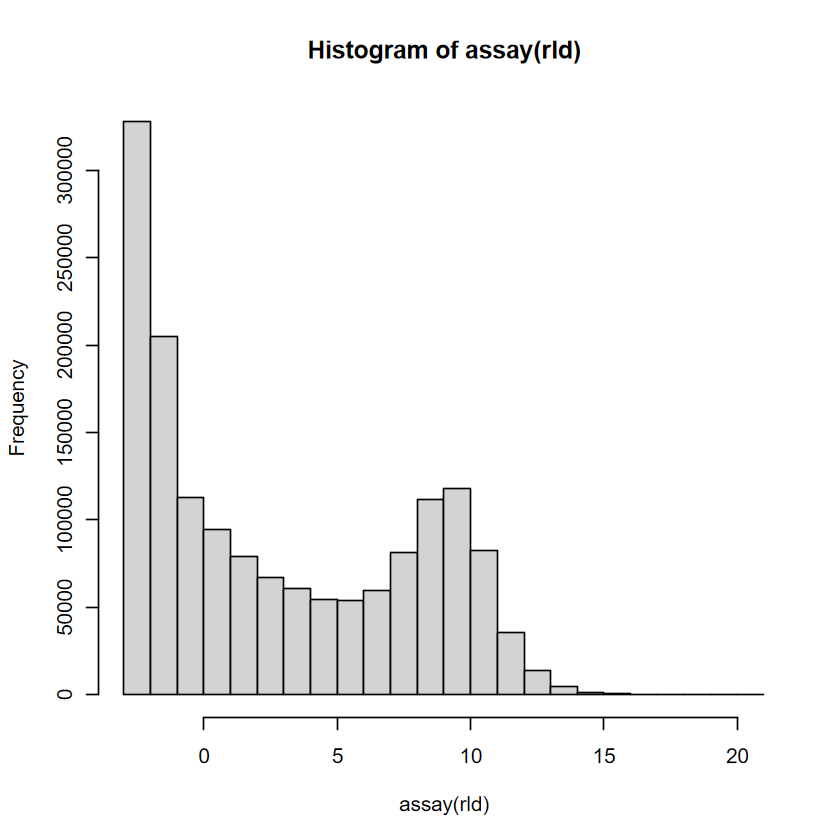

In [46]:
rld <- rlog(dds)
head(assay(rld))
hist(assay(rld))

In [47]:
mycols <- brewer.pal(3, "Dark2")[1:length(unique(colData$resp2))]

In [48]:
sampleDists <- as.matrix(dist(t(assay(rld))))
rownames(sampleDists) = paste(sapply(strsplit(rownames(sampleDists), "_"),`[`, 3),"_",sapply(strsplit(rownames(sampleDists), "_"),`[`, 4))
colnames(sampleDists) = paste(sapply(strsplit(colnames(sampleDists), "_"),`[`, 3),"_",sapply(strsplit(colnames(sampleDists), "_"),`[`, 4))
names(mycols) <- levels(as.factor(colData$resp2))  # Name the colors after the levels of resp2

ColSideColors <- mycols[colData$resp2]
RowSideColors <- mycols[colData$resp2]  
pdf(paste0(fold, "qc-heatmap-samples.pdf"), 6, 6)
heatmap.2(as.matrix(sampleDists), key=F, trace="none",
          col=colorpanel(100, "black", "white"),
          ColSideColors=ColSideColors, RowSideColors=RowSideColors,
          margin=c(10, 10), cexRow=0.6,  # Adjust row label size
          cexCol=0.6, main="Sample Distance Matrix")
dev.off()


pdf 
  2

In [50]:
heat = as.matrix(dist(t(assay(rld))))

In [ ]:
#cleaning the rownames and colnames
rownames(heat) = lapply(rownames(heat), function(x) paste(strsplit(x, "_")[[1]][3], strsplit(x, "_")[[1]][4], sep = "_"))
colnames(heat)= lapply(colnames(heat), function(x) paste(strsplit(x, "_")[[1]][3], strsplit(x, "_")[[1]][4], sep = "_"))

In [71]:
pdf(paste0(fold, "qc-heatmap-samples2.pdf"), 6, 6)
Heatmap(heat,
       top_annotation = HeatmapAnnotation(Subtypes = colData$Subtype , Cond = colData$resp2),
       show_heatmap_legend = FALSE,
        row_names_gp = gpar(fontsize = 6),  # Reduce row label font size
        column_names_gp = gpar(fontsize = 6) )
dev.off()

pdf 
  2

In [54]:
rld_pca <- function(rld, intgroup = "condition", ntop = 500, colors = NULL, legendpos = "bottomleft", main = "PCA", textcx = 0.4, shapevar = NULL, ...) {
  require(genefilter)
  require(calibrate)
  require(RColorBrewer)

  # Calculate the row variances
  rv = rowVars(assay(rld))
  select = order(rv, decreasing = TRUE)[seq_len(min(ntop, length(rv)))]

  # Perform PCA
  pca = prcomp(t(assay(rld)[select, ]))
  
  # Prepare labels for text
  lab = sapply(strsplit(rownames(as.data.frame(pca$x)), "_"), `[`, 3)

  # Factor for the grouping variable
  fac = factor(apply(as.data.frame(colData(rld)[, intgroup, drop = FALSE]), 1, paste, collapse = " : "))

  # Set colors for the groups if not provided
  if (is.null(colors)) {
    if (nlevels(fac) >= 3) {
      colors = brewer.pal(nlevels(fac), "Paired")
    } else {
      colors = c("black", "red")
    }
  }

  # Get the explained variance for PC1 and PC2
  pc1var <- round(summary(pca)$importance[2, 1] * 100, digits = 1)
  pc2var <- round(summary(pca)$importance[2, 2] * 100, digits = 1)
  pc1lab <- paste0("PC1 (", as.character(pc1var), "%)")
  pc2lab <- paste0("PC2 (", as.character(pc2var), "%)")

  # Assign shapes based on shapevar ('LUM' and 'TN')
  if (!is.null(shapevar)) {
    shape_var = factor(colData(rld)[, shapevar])  # Factor variable for shapes
    shapes <- ifelse(shape_var == "LUM", 16, 17)  # 16 = solid circle, 17 = triangle
  } else {
    shapes <- rep(16, length(fac))  # Default to solid circle if no shapevar provided
  }

  # Create PCA plot
  plot(pca$x[, 2] ~ pca$x[, 1], data = as.data.frame(pca$x), col = colors[fac], pch = shapes, xlab = pc1lab, ylab = pc2lab, main = main, ...)

  # Add text labels
  with(as.data.frame(pca$x), textxy(PC1, PC2, labs = lab, cex = textcx))

  if (!is.null(shapevar)) {
    # Create a custom legend with both color and shape
    legend(legendpos, 
           legend = c(levels(fac),levels(shape_var)), 
           col = c(colors, rep("black", length(unique(shape_var)))), 
           pch = c(rep(16, length(levels(fac))), 16, 17),  # Different shapes for the shapevar levels
           title = "Legend")
  } else {
    # If no shapevar, only use color in the legend
    legend(legendpos, 
           legend = levels(fac), 
           col = colors, 
           pch = 16, 
           title = "Legend")
  }
}


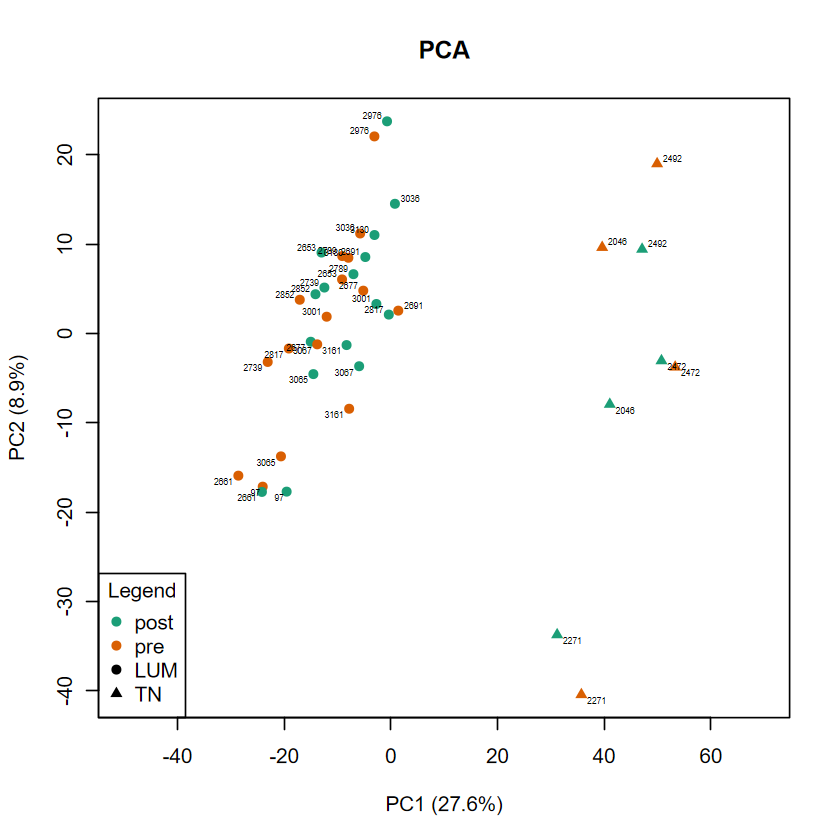

In [55]:
rld_pca(rld, colors = mycols, intgroup="resp2", xlim=c(-50, 70),shapevar ="Subtype")

In [56]:
pdf(paste0(fold,"qc-pca.pdf"), 6, 6)
rld_pca(rld, colors = mycols, intgroup="resp2", xlim=c(-50, 70),shapevar ="Subtype")
dev.off()

pdf 
  2

In [35]:
resdata  %>%  head

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,X3597_1_97_B_AACGTGAT,X3597_2_97_S_AAACATCG,X3597_3_2046_B_ATGCCTAA,⋯,X3597_37_3130_B_CCGAAGTA,X3597_38_3130_S_CCGTGAGA,X3597_39_3161_B_CCTCCTGA,X3597_40_3161_S_CGAACTTA,gene_biotype,chromosome_name,start_position,end_position,external_gene_id,description
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<chr>
1,ENSG00000164949,894.20841,2.3117461,0.19149848,12.071877,1.487038e-33,3.223006e-29,90.46093,574.38966,148.97396,⋯,326.77607,1303.398839,434.40655,1019.51460,protein_coding,8,95261481,95274578,GEM,GTP binding protein overexpressed in skeletal muscle [Source:HGNC Symbol;Acc:4234]
2,ENSG00000187955,6083.70690,2.3808647,0.22043253,10.800877,3.409310e-27,3.694669e-23,534.98400,2415.72734,77.14723,⋯,6159.90344,23450.162070,8017.12804,13701.97234,protein_coding,8,121072019,121384275,COL14A1,"collagen, type XIV, alpha 1 [Source:HGNC Symbol;Acc:2191]"
3,ENSG00000102189,790.03510,0.6522355,0.06188234,10.539930,5.654070e-26,4.084877e-22,584.59160,918.42513,474.85451,⋯,684.95056,1436.450606,740.81831,1067.17484,protein_coding,12,93164413,93323107,EEA1,early endosome antigen 1 [Source:HGNC Symbol;Acc:3185]
4,ENSG00000240184,524.56882,1.3468676,0.13492937,9.982019,1.827099e-23,9.900135e-20,209.13011,425.55692,85.12798,⋯,594.24404,1511.874856,694.27476,914.52394,protein_coding,5,140855580,140892542,PCDHGC3,"protocadherin gamma subfamily C, 3 [Source:HGNC Symbol;Acc:8716]"
5,ENSG00000232810,63.32949,-2.0890107,0.21000301,-9.947527,2.585269e-23,1.120663e-19,47.66221,29.91613,111.73047,⋯,43.02745,6.779708,25.85753,3.45364,protein_coding,6,31543344,31546113,TNF,tumor necrosis factor [Source:HGNC Symbol;Acc:11892]
6,ENSG00000017427,1368.64534,2.0028824,0.20303158,9.864881,5.910437e-23,2.135047e-19,179.94916,1020.88787,89.11835,⋯,823.33616,2673.747292,562.40134,2274.56747,protein_coding,12,102789645,102874423,IGF1,insulin-like growth factor 1 (somatomedin C) [Source:HGNC Symbol;Acc:5464]


In [36]:
resdata  %>%  nrow()

[1] 39117

In [37]:
resdata2 = resdata %>%
  relocate(external_gene_id, .before = everything())

In [39]:
degs = resdata2 %>% filter(abs(log2FoldChange)>=1 & padj < 0.05)
up=degs %>% filter(log2FoldChange>=1)
down = degs %>% filter(log2FoldChange<=-1)

In [ ]:
#writing results for downstream analysis
write.csv( resdata2  %>% filter(abs(log2FoldChange)>=1 & padj < 0.05), paste0(fold,'degs.csv'), row.names=FALSE)
write.csv( resdata2, paste0(fold,'result.csv'),row.names=FALSE)
write.csv( counts(dds, normalized=TRUE), paste0(fold,'normalized_counts.csv'),row.names=FALSE) # normalized counts

In [ ]:
#for EnrichR
write.csv( na.omit(up$external_gene_id), paste0(fold,'up.csv'), row.names=FALSE, quote = FALSE )
write.csv( na.omit(down$external_gene_id), paste0(fold,'down.csv'), row.names=FALSE,quote = FALSE)
write.csv( na.omit(resdata2$external_gene_id), paste0(fold,'background.csv'), row.names=FALSE,quote = FALSE )

In [ ]:
#results in excel format for sharing
write_xlsx( degs, paste0(fold,'degs.xlsx'))
write_xlsx( resdata2, paste0(fold,'result.xlsx'))
write_xlsx( as.data.frame(counts(dds, normalized=TRUE)), paste0(fold,'normalized_counts.xlsx')) # normalized counts

In [40]:
degs  %>% nrow()

[1] 902

In [ ]:
#taking a look to the top statistically deregulated genes
degs %>% dplyr::select(external_gene_id,baseMean,log2FoldChange,padj) %>% 
arrange(-abs(log2FoldChange)) %>% head(20)

,external_gene_id,baseMean,log2FoldChange,padj
,<chr>,<dbl>,<dbl>,<dbl>
1,MSMB,74.841340,-3.611760,1.143924e-05
2,PHGR1,121.864644,-3.471996,9.320602e-06
3,NEFL,61.282104,3.074571,7.542895e-13
4,CYR61,5705.910744,3.037916,2.647946e-19
5,TFF1,3643.870294,-2.927296,3.330588e-08
6,PTCHD4,42.171911,2.875250,1.233776e-12
7,RIMS4,603.892835,-2.850879,2.179502e-06
8,NKAIN1,612.734818,-2.849746,6.338649e-07
9,CALN1,18.112266,2.754007,8.071963e-06


In [54]:
sprintf("up regulated genes: %d", degs  %>% filter(log2FoldChange>=1)  %>% nrow)

[1] "up regulated genes: 606"

In [55]:
sprintf("down regulated genes: %d",degs  %>% filter(log2FoldChange<=-1)  %>% nrow)

[1] "down regulated genes: 296"

In [ ]:
#extracellular matric organization genes
EMO = c("COL17A1","TNXB","COL16A1","LAMA2","COL14A1","LAMA1","ELN","SERPINE1","TNC","HTRA1","LRP4","FBLN1","FGF2","FBLN2","ADAMTS16","ADAMTS5","ADAMTS3","CAPN6","ADAMTS1","CTSG","NCAM1","COL25A1","CMA1","MMP2","MMP3","GDF5","ASPN","DCN","COL1A1","MFAP4","COL3A1","BMP2","COL1A2","MMP16","COL5A1","COL6A2","ADAM12","COL5A2","COL6A1","ITGA8","COL8A1","MMP19","COL6A3","COL6A6","FBN1")

In [ ]:
#top 20 deregulated genes belonging to EMO
degs %>% dplyr::select(external_gene_id,baseMean,log2FoldChange,padj) %>% 
filter(external_gene_id %in% EMO)  %>% 
arrange(-abs(log2FoldChange))  %>% head(20)

,external_gene_id,baseMean,log2FoldChange,padj
,<chr>,<dbl>,<dbl>,<dbl>
1,COL14A1,6083.70690,2.380865,3.694669e-23
2,MFAP4,2106.71270,2.318864,1.671580e-17
3,ELN,4405.16989,1.997073,2.847689e-14
4,SERPINE1,1718.71523,1.988166,1.637581e-06
5,CMA1,18.14640,1.922716,8.486344e-04
6,CTSG,72.06075,1.819214,2.410059e-04
7,CAPN6,304.15987,1.739471,1.284745e-04
8,ADAMTS16,314.41964,1.734161,2.218534e-04
9,MMP2,20739.72871,1.716964,1.209227e-09


# heatmap of collagens and DNA damage

In [57]:
fold = '../../breast/ALL/'

In [58]:
resdata =read.table(paste0(fold,"result.csv"),
                 header=TRUE, sep = ",",quote = "\"", fill = TRUE, comment.char = "", 
                 stringsAsFactors = FALSE)

In [60]:
resdata  %>%  head(3)

,external_gene_id,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,X3597_1_97_B_AACGTGAT,X3597_2_97_S_AAACATCG,⋯,X3597_36_3067_S_CCAGTTCA,X3597_37_3130_B_CCGAAGTA,X3597_38_3130_S_CCGTGAGA,X3597_39_3161_B_CCTCCTGA,X3597_40_3161_S_CGAACTTA,gene_biotype,chromosome_name,start_position,end_position,description
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>
1,GEM,ENSG00000164949,894.2084,2.3117461,0.19149848,12.07188,1.487038e-33,3.223006e-29,90.46093,574.3897,⋯,2702.464,326.7761,1303.399,434.4066,1019.515,protein_coding,8,95261481,95274578,GTP binding protein overexpressed in skeletal muscle [Source:HGNC Symbol;Acc:4234]
2,COL14A1,ENSG00000187955,6083.7069,2.3808647,0.22043253,10.80088,3.409310e-27,3.694669e-23,534.98400,2415.7273,⋯,16354.389,6159.9034,23450.162,8017.1280,13701.972,protein_coding,8,121072019,121384275,"collagen, type XIV, alpha 1 [Source:HGNC Symbol;Acc:2191]"
3,EEA1,ENSG00000102189,790.0351,0.6522355,0.06188234,10.53993,5.654070e-26,4.084877e-22,584.59160,918.4251,⋯,1152.710,684.9506,1436.451,740.8183,1067.175,protein_coding,12,93164413,93323107,early endosome antigen 1 [Source:HGNC Symbol;Acc:3185]


In [ ]:
resdata  %>% filter(abs(log2FoldChange)>=1, padj<.05)  %>% 
                column_to_rownames("external_gene_id")  %>% 
                arrange(-abs(log2FoldChange)) %>% 
                dplyr::select(log2FoldChange, padj)  %>% head(20)

,log2FoldChange,padj
,<dbl>,<dbl>
MSMB,-3.611760,1.143924e-05
PHGR1,-3.471996,9.320602e-06
NEFL,3.074571,7.542895e-13
CYR61,3.037916,2.647946e-19
TFF1,-2.927296,3.330588e-08
PTCHD4,2.875250,1.233776e-12
RIMS4,-2.850879,2.179502e-06
NKAIN1,-2.849746,6.338649e-07
CALN1,2.754007,8.071963e-06


In [ ]:
#checking at genes belonging to EMO (EnrichR)
resdata  %>% 
filter(log2FoldChange>=1, padj<.05,
       external_gene_id %in% c("SPARC","ITGB5","COL14A1","ITGB4","ELN","COL12A1","LAMC2","CTSV","FGF2","LOXL1","COMP","EFEMP2","MMP24","EFEMP1","SH3PXD2A","TNN","DAG1","TIMP2","ITGB6","TPSAB1","MMP2","MMP3","P3H2","BGN","DCN","MMP14","MMP13","LOX","COL8A2","COL8A1","MATN3","COL17A1","FBN2","SDC4","LAMA2","LAMA1","SDC2","LAMA3","HTRA1","FBLN1","LTBP2","FBLN2","THBS1","KLK7","FBLN5","TGFB2","LAMB3","TGFB3","LUM","COL1A1","MFAP5","MFAP4","COL3A1","COL1A2","P4HA3","SDC1","TLL1","FMOD","FBN1")) %>% 
       dplyr::select(external_gene_id,log2FoldChange, padj)  %>% arrange(-abs(log2FoldChange)) 

external_gene_id,log2FoldChange,padj
<chr>,<dbl>,<dbl>
COL14A1,2.380865,3.694669e-23
MFAP4,2.318864,1.671580e-17
ELN,1.997073,2.847689e-14
MMP2,1.716964,1.209227e-09
COL1A1,1.694849,8.849516e-03
COL1A2,1.662282,7.412082e-03
COL3A1,1.606619,8.125883e-03
FBLN1,1.592054,9.624708e-09
COL17A1,1.562844,3.785094e-04


In [11]:
msigdbr_collections()

gs_cat,gs_subcat,num_genesets
<chr>,<chr>,<int>
C1,,299
C2,CGP,3384
C2,CP,29
C2,CP:BIOCARTA,292
C2,CP:KEGG,186
C2,CP:PID,196
C2,CP:REACTOME,1615
C2,CP:WIKIPATHWAYS,664
C3,MIR:MIRDB,2377


In [12]:
msigdb_genes <- msigdbr(species = "Homo sapiens", category = "C2",subcategory = "CP:REACTOME")  # Hallmark pathways
pathways <- split(msigdb_genes$gene_symbol, msigdb_genes$gs_name)

In [13]:
dna_damage_pathways <- pathways[grepl("DNA_DAMAGE", names(pathways))]

# Print pathway names
names(dna_damage_pathways)

[1] "REACTOME_DNA_DAMAGE_BYPASS"                                               
[2] "REACTOME_DNA_DAMAGE_RECOGNITION_IN_GG_NER"                                
[3] "REACTOME_DNA_DAMAGE_REVERSAL"                                             
[4] "REACTOME_DNA_DAMAGE_TELOMERE_STRESS_INDUCED_SENESCENCE"                   
[5] "REACTOME_G1_S_DNA_DAMAGE_CHECKPOINTS"                                     
[6] "REACTOME_G2_M_DNA_DAMAGE_CHECKPOINT"                                      
[7] "REACTOME_RECOGNITION_OF_DNA_DAMAGE_BY_PCNA_CONTAINING_REPLICATION_COMPLEX"
[8] "REACTOME_SUMOYLATION_OF_DNA_DAMAGE_RESPONSE_AND_REPAIR_PROTEINS"

In [14]:
dna_damage_pathways$REACTOME_G2_M_DNA_DAMAGE_CHECKPOINT

[1] "ABRAXAS1" "ATM"      "ATR"      "ATRIP"    "BABAM1"   "BABAM2"  
  [7] "BARD1"    "BLM"      "BRCA1"    "BRCC3"    "BRIP1"    "CCNB1"   
 [13] "CDC25C"   "CDK1"     "CHEK1"    "CHEK2"    "DNA2"     "EXO1"    
 [19] "H2AX"     "H2BC1"    "H2BC10"   "H2BC11"   "H2BC12"   "H2BC13"  
 [25] "H2BC14"   "H2BC15"   "H2BC17"   "H2BC21"   "H2BC3"    "H2BC4"   
 [31] "H2BC5"    "H2BC6"    "H2BC7"    "H2BC8"    "H2BC9"    "H2BS1"   
 [37] "H2BU1"    "H2BU1"    "H3-4"     "H3-4"     "H4-16"    "H4C1"    
 [43] "H4C11"    "H4C12"    "H4C13"    "H4C14"    "H4C15"    "H4C2"    
 [49] "H4C3"     "H4C4"     "H4C5"     "H4C6"     "H4C8"     "H4C9"    
 [55] "HERC2"    "HUS1"     "KAT5"     "MDC1"     "MDC1"     "MDC1"    
 [61] "MDC1"     "MDC1"     "MDC1"     "MDC1"     "MDC1"     "MRE11"   
 [67] "NBN"      "NSD2"     "PIAS4"    "RAD1"     "RAD17"    "RAD17"   
 [73] "RAD50"    "RAD9A"    "RAD9B"    "RBBP8"    "RFC2"     "RFC3"    
 [79] "RFC4"     "RFC5"     "RHNO1"    "RMI1"     "RMI2"     "RNF168"  
 [85] "RNF8"     "RPA1"     "RPA2"     "RPA3"     "SFN"      "SUMO1"   
 [91] "TOP3A"    "TOP3A"    "TOPBP1"   "TP53"     "TP53BP1"  "UBE2N"   
 [97] "UBE2V2"   "UIMC1"    "WEE1"     "WRN"      "YWHAB"    "YWHAE"   
[103] "YWHAE"    "YWHAG"    "YWHAH"    "YWHAQ"    "YWHAZ"

In [15]:
tmp = resdata  %>% filter(external_gene_id  %in% dna_damage_pathways$REACTOME_G2_M_DNA_DAMAGE_CHECKPOINT) 
tmp %>% nrow()

[1] 57

In [16]:
rownames(tmp) <- tmp$external_gene_id
tmp = tmp %>% dplyr::select(log2FoldChange, padj)

In [17]:
tmp  %>% filter(abs(log2FoldChange)>=1, padj<0.05)

,log2FoldChange,padj
,<dbl>,<dbl>
CDK1,-1.633028,2.068183e-06
CHEK1,-1.053073,4.709344e-05
CCNB1,-1.055901,4.923417e-05
CDC25C,-1.623054,6.065857e-05
EXO1,-1.362794,1.056856e-03


In [18]:
collagen_pathways <- pathways[grepl("COLLAGEN|FIBRONECTIN|EXTRACELLULAR_MATRIX", names(pathways))]

# Print pathway names
names(collagen_pathways)

[1] "REACTOME_ASSEMBLY_OF_COLLAGEN_FIBRILS_AND_OTHER_MULTIMERIC_STRUCTURES"
 [2] "REACTOME_CELL_EXTRACELLULAR_MATRIX_INTERACTIONS"                      
 [3] "REACTOME_COLLAGEN_BIOSYNTHESIS_AND_MODIFYING_ENZYMES"                 
 [4] "REACTOME_COLLAGEN_CHAIN_TRIMERIZATION"                                
 [5] "REACTOME_COLLAGEN_DEGRADATION"                                        
 [6] "REACTOME_COLLAGEN_FORMATION"                                          
 [7] "REACTOME_CROSSLINKING_OF_COLLAGEN_FIBRILS"                            
 [8] "REACTOME_DEGRADATION_OF_THE_EXTRACELLULAR_MATRIX"                     
 [9] "REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION"                           
[10] "REACTOME_FIBRONECTIN_MATRIX_FORMATION"                                
[11] "REACTOME_PLATELET_ADHESION_TO_EXPOSED_COLLAGEN"

In [19]:
collagen_pathways$REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION

[1] "A2M"      "ACAN"     "ACTN1"    "ADAM10"   "ADAM12"   "ADAM15"  
  [7] "ADAM17"   "ADAM19"   "ADAM8"    "ADAM9"    "ADAMTS1"  "ADAMTS14"
 [13] "ADAMTS16" "ADAMTS18" "ADAMTS2"  "ADAMTS2"  "ADAMTS3"  "ADAMTS4" 
 [19] "ADAMTS5"  "ADAMTS8"  "ADAMTS9"  "AGRN"     "APP"      "ASPN"    
 [25] "BCAN"     "BGN"      "BMP1"     "BMP10"    "BMP2"     "BMP4"    
 [31] "BMP7"     "BSG"      "CAPN1"    "CAPN10"   "CAPN11"   "CAPN12"  
 [37] "CAPN13"   "CAPN14"   "CAPN15"   "CAPN2"    "CAPN3"    "CAPN5"   
 [43] "CAPN6"    "CAPN7"    "CAPN8"    "CAPN9"    "CAPNS1"   "CAPNS2"  
 [49] "CASK"     "CASP3"    "CAST"     "CD151"    "CD44"     "CD47"    
 [55] "CDH1"     "CEACAM1"  "CEACAM6"  "CEACAM8"  "CMA1"     "COL10A1" 
 [61] "COL11A1"  "COL11A2"  "COL11A2"  "COL11A2"  "COL11A2"  "COL11A2" 
 [67] "COL12A1"  "COL13A1"  "COL14A1"  "COL15A1"  "COL16A1"  "COL17A1" 
 [73] "COL18A1"  "COL19A1"  "COL1A1"   "COL1A2"   "COL20A1"  "COL21A1" 
 [79] "COL22A1"  "COL23A1"  "COL24A1"  "COL25A1"  "COL26A1"  "COL27A1" 
 [85] "COL28A1"  "COL2A1"   "COL3A1"   "COL4A1"   "COL4A2"   "COL4A3"  
 [91] "COL4A4"   "COL4A5"   "COL4A6"   "COL5A1"   "COL5A2"   "COL5A3"  
 [97] "COL6A1"   "COL6A2"   "COL6A3"   "COL6A5"   "COL6A6"   "COL7A1"  
[103] "COL8A1"   "COL8A2"   "COL9A1"   "COL9A2"   "COL9A3"   "COLGALT1"
[109] "COLGALT2" "COMP"     "CRTAP"    "CTRB1"    "CTRB2"    "CTSB"    
[115] "CTSB"     "CTSD"     "CTSG"     "CTSK"     "CTSL"     "CTSS"    
[121] "CTSV"     "DAG1"     "DCN"      "DDR1"     "DDR1"     "DDR1"    
[127] "DDR1"     "DDR1"     "DDR2"     "DMD"      "DMP1"     "DSPP"    
[133] "DST"      "EFEMP1"   "EFEMP2"   "ELANE"    "ELANE"    "ELN"     
[139] "EMILIN1"  "EMILIN2"  "EMILIN3"  "F11R"     "FBLN1"    "FBLN2"   
[145] "FBLN5"    "FBN1"     "FBN2"     "FBN3"     "FGA"      "FGB"     
[151] "FGF2"     "FGG"      "FMOD"     "FN1"      "FURIN"    "GDF5"    
[157] "HAPLN1"   "HSPG2"    "HTRA1"    "IBSP"     "ICAM1"    "ICAM2"   
[163] "ICAM3"    "ICAM4"    "ICAM5"    "ITGA1"    "ITGA10"   "ITGA11"  
[169] "ITGA2"    "ITGA2B"   "ITGA3"    "ITGA4"    "ITGA5"    "ITGA6"   
[175] "ITGA7"    "ITGA8"    "ITGA9"    "ITGAD"    "ITGAE"    "ITGAL"   
[181] "ITGAM"    "ITGAV"    "ITGAX"    "ITGB1"    "ITGB2"    "ITGB3"   
[187] "ITGB4"    "ITGB5"    "ITGB6"    "ITGB7"    "ITGB8"    "JAM2"    
[193] "JAM3"     "KDR"      "KLK2"     "KLK7"     "KLKB1"    "LAMA1"   
[199] "LAMA2"    "LAMA3"    "LAMA4"    "LAMA5"    "LAMB1"    "LAMB2"   
[205] "LAMB3"    "LAMC1"    "LAMC2"    "LAMC3"    "LOX"      "LOXL1"   
[211] "LOXL2"    "LOXL3"    "LOXL4"    "LRP4"     "LTBP1"    "LTBP2"   
[217] "LTBP3"    "LTBP4"    "LUM"      "MADCAM1"  "MATN1"    "MATN3"   
[223] "MATN4"    "MFAP1"    "MFAP2"    "MFAP3"    "MFAP4"    "MFAP5"   
[229] "MMP1"     "MMP10"    "MMP11"    "MMP11"    "MMP12"    "MMP13"   
[235] "MMP14"    "MMP15"    "MMP16"    "MMP17"    "MMP19"    "MMP2"    
[241] "MMP20"    "MMP24"    "MMP25"    "MMP3"     "MMP7"     "MMP8"    
[247] "MMP9"     "MUSK"     "NCAM1"    "NCAN"     "NCSTN"    "NID1"    
[253] "NID2"     "NRXN1"    "NTN4"     "OPTC"     "P3H1"     "P3H2"    
[259] "P3H3"     "P4HA1"    "P4HA2"    "P4HA3"    "P4HB"     "PCOLCE"  
[265] "PCOLCE2"  "PDGFA"    "PDGFB"    "PECAM1"   "PHYKPL"   "PLEC"    
[271] "PLG"      "PLOD1"    "PLOD2"    "PLOD3"    "PPIB"     "PRKCA"   
[277] "PRSS1"    "PRSS1"    "PRSS2"    "PRSS2"    "PSEN1"    "PTPRS"   
[283] "PXDN"     "SCUBE1"   "SCUBE3"   "SDC1"     "SDC2"     "SDC3"    
[289] "SDC4"     "SERPINE1" "SERPINH1" "SH3PXD2A" "SPARC"    "SPOCK3"  
[295] "SPP1"     "TGFB1"    "TGFB2"    "TGFB3"    "THBS1"    "TIMP1"   
[301] "TIMP2"    "TLL1"     "TLL2"     "TMPRSS6"  "TNC"      "TNN"     
[307] "TNR"      "TNXB"     "TNXB"     "TNXB"     "TPSAB1"   "TRAPPC4" 
[313] "TRAPPC4"  "TTR"      "VCAM1"    "VCAN"     "VTN"      "VWF"

In [20]:
tmp = resdata  %>% filter(external_gene_id  %in% collagen_pathways$REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION)  %>% 
filter(padj<.05, abs(log2FoldChange)>=1)
tmp %>% nrow()

[1] 49

In [21]:
as.data.frame(tmp)  %>% dplyr::select(external_gene_id,log2FoldChange,padj)

external_gene_id,log2FoldChange,padj
<chr>,<dbl>,<dbl>
COL14A1,2.380865,3.694669e-23
MFAP4,2.318864,1.671580e-17
ELN,1.997073,2.847689e-14
LAMA2,1.560029,2.638210e-13
MMP2,1.716964,1.209227e-09
ADAMTS5,1.185043,7.315872e-09
FBLN1,1.592054,9.624708e-09
COL6A3,1.460533,1.003136e-06
MMP16,1.213761,1.021772e-06


# GSEA

In [25]:
msigdbr_collections()

gs_cat,gs_subcat,num_genesets
<chr>,<chr>,<int>
C1,,299
C2,CGP,3384
C2,CP,29
C2,CP:BIOCARTA,292
C2,CP:KEGG,186
C2,CP:PID,196
C2,CP:REACTOME,1615
C2,CP:WIKIPATHWAYS,664
C3,MIR:MIRDB,2377


In [26]:
msigdb_genes <- msigdbr(species = "Homo sapiens", category = "C2", subcategory = "CP:REACTOME")  # Hallmark pathways
pathways <- split(msigdb_genes$ensembl_gene, msigdb_genes$gs_name)

In [27]:
msigdb_genes  %>%  head(2)

gs_cat,gs_subcat,gs_name,gene_symbol,entrez_gene,ensembl_gene,human_gene_symbol,human_entrez_gene,human_ensembl_gene,gs_id,gs_pmid,gs_geoid,gs_exact_source,gs_url,gs_description
<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
C2,CP:REACTOME,REACTOME_2_LTR_CIRCLE_FORMATION,BANF1,8815,ENSG00000175334,BANF1,8815,ENSG00000175334,M26996,,,R-HSA-164843,https://www.reactome.org/content/detail/R-HSA-164843|https://reactome.org/PathwayBrowser/#/R-HSA-164843,2-LTR circle formation
C2,CP:REACTOME,REACTOME_2_LTR_CIRCLE_FORMATION,HMGA1,3159,ENSG00000137309,HMGA1,3159,ENSG00000137309,M26996,,,R-HSA-164843,https://www.reactome.org/content/detail/R-HSA-164843|https://reactome.org/PathwayBrowser/#/R-HSA-164843,2-LTR circle formation


In [28]:
resdata$pvalue[resdata$pvalue == 0] <- min(resdata$pvalue[resdata$pvalue > 0], na.rm = TRUE)

In [29]:
resdata  %>% head(2)

,external_gene_id,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,X3597_1_97_B_AACGTGAT,X3597_2_97_S_AAACATCG,⋯,X3597_36_3067_S_CCAGTTCA,X3597_37_3130_B_CCGAAGTA,X3597_38_3130_S_CCGTGAGA,X3597_39_3161_B_CCTCCTGA,X3597_40_3161_S_CGAACTTA,gene_biotype,chromosome_name,start_position,end_position,description
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>
1,GEM,ENSG00000164949,894.2084,2.311746,0.1914985,12.07188,1.487038e-33,3.223006e-29,90.46093,574.3897,⋯,2702.464,326.7761,1303.399,434.4066,1019.515,protein_coding,8,95261481,95274578,GTP binding protein overexpressed in skeletal muscle [Source:HGNC Symbol;Acc:4234]
2,COL14A1,ENSG00000187955,6083.7069,2.380865,0.2204325,10.80088,3.409310e-27,3.694669e-23,534.98400,2415.7273,⋯,16354.389,6159.9034,23450.162,8017.1280,13701.972,protein_coding,8,121072019,121384275,"collagen, type XIV, alpha 1 [Source:HGNC Symbol;Acc:2191]"


In [ ]:
#Combined Score used for ranking genes
resdata$CS = sign(resdata$log2FoldChange) * -log10(resdata$pvalue) 
resdata$Rank <- rank(-resdata$CS)

In [31]:
resdata = resdata[order(resdata$Rank),]

In [32]:
stats <- resdata$CS
names(stats) <- resdata$Gene
length(stats)

[1] 39117

In [33]:
sum(is.na(stats))    # Count NA values
sum(is.nan(stats))   # Count NaN values
sum(is.infinite(stats))  # Count Inf/-Inf values

[1] 0

[1] 0

[1] 0

In [34]:
stats[is.na(stats)][1]

<NA> 
  NA

In [36]:
stats[is.na(stats)] <- 0

In [37]:
# Perform GSEA
fgsea_results <- fgseaMultilevel(pathways = pathways, stats = stats)

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (10.88% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."


In [38]:
res = fgsea_results[fgsea_results$padj<0.05,c("pathway","padj","NES")]
res[order(res$NES),]

pathway,padj,NES
<chr>,<dbl>,<dbl>
REACTOME_TRANSLATION,1.997053e-37,-2.582347
REACTOME_RESPIRATORY_ELECTRON_TRANSPORT_ATP_SYNTHESIS_BY_CHEMIOSMOTIC_COUPLING_AND_HEAT_PRODUCTION_BY_UNCOUPLING_PROTEINS,1.468011e-19,-2.444255
REACTOME_RESPIRATORY_ELECTRON_TRANSPORT,1.674767e-16,-2.395200
REACTOME_DNA_REPLICATION,7.459778e-19,-2.393308
REACTOME_SRP_DEPENDENT_COTRANSLATIONAL_PROTEIN_TARGETING_TO_MEMBRANE,9.635000e-17,-2.386925
REACTOME_SYNTHESIS_OF_DNA,1.713300e-16,-2.373351
REACTOME_MITOCHONDRIAL_TRANSLATION,4.589651e-15,-2.360769
REACTOME_EUKARYOTIC_TRANSLATION_INITIATION,1.063231e-15,-2.347621
REACTOME_RRNA_PROCESSING,4.823510e-18,-2.346580


In [39]:
res2 = fgsea_results  %>% filter(str_detect(pathway, "ECM|DNA_DAMAGE|EXTRACELLULAR_MATRIX|COLLAGEN|FIBRONECTIN"))

In [123]:
g2=ggplot(res2, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill=padj<0.05)) +
  coord_flip() +
  labs(x="Pathway", y="Normalized Enrichment Score",
       title="",
       subtitle = "genes rank = -log10(pvalue) * sign(log2FoldChange)"
  ) +
  scale_fill_manual(
    values = c("TRUE" = "red", "FALSE" = "lightgray"), # Specifica i colori
    name = "padj < 0.05"                      # Legenda personalizzata
  ) +
  theme_minimal() + theme(axis.text = element_text(size = 8))

pdf(paste0(fold,"FGSEA.pdf"), width =10, height=10)
g2
dev.off()

pdf 
  2

In [40]:
topPathwaysUp <- fgsea_results[NES > 0][head(order(padj), n=10), pathway]
topPathwaysDown <- fgsea_results[NES < 0][head(order(padj), n=10), pathway]

In [125]:
topPathways <- c(topPathwaysUp, rev(topPathwaysDown))
png(paste0(fold,"GSEA.png")) 
plotGseaTable(pathways[topPathways], stats, fgsea_results, 
              gseaParam=0.5)
dev.off()

pdf 
  2

In [41]:
fgsea_results %>% head()

pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
REACTOME_2_LTR_CIRCLE_FORMATION,0.24782609,0.4543009,0.12750532,-0.7603309,-1.2189882,7,ENSG0000....
REACTOME_ABACAVIR_METABOLISM,0.64854369,0.7965004,0.06450312,0.5954957,0.8977391,5,ENSG0000....
REACTOME_ABACAVIR_TRANSMEMBRANE_TRANSPORT,0.19029126,0.3827153,0.13880511,0.8363794,1.2608831,5,ENSG0000....
REACTOME_ABACAVIR_TRANSPORT_AND_METABOLISM,0.28880866,0.4961811,0.10473282,0.7052228,1.1760599,10,ENSG0000....
REACTOME_ABC_FAMILY_PROTEINS_MEDIATED_TRANSPORT,0.04477865,0.1599945,0.32177592,-0.4717782,-1.3071555,102,ENSG0000....
REACTOME_ABC_TRANSPORTERS_IN_LIPID_HOMEOSTASIS,0.25044092,0.4565035,0.11237852,0.6473791,1.1866303,18,ENSG0000....


# GSVA

In [ ]:
drawline = function(long_data, path, fold, print=FALSE){

lines = long_data %>% filter(Pathway==path) %>% 
    mutate(Patient = sapply(strsplit(as.character(Patient), "_"), function(x) x[3]))  %>%  
    dplyr::select(Patient, GSVA_Score, Patient_Type) %>%
    pivot_wider(names_from = Patient_Type, values_from = GSVA_Score)


    plot = ggplot(lines) +
      geom_segment(aes(x = 0, xend = 10, y=B, yend = S), color = "black", size = 1) +
      geom_point(aes(x = 0,y=B), color = "light blue", size = 3) +  # Mark x1
      geom_point(aes(x = 10,y=S), color = "orange", size = 3) +  # Mark x2
      theme_minimal() +
      theme(axis.title.x = element_blank(),  # Hide x-axis label
            axis.text.x = element_blank(),
           plot.title = element_text(size = 8)) + 
      labs(x = "", y = "GSVA SCORE", title = path)
    if(print){
        pdf(paste0(fold,path,"_line.pdf"),width=5,height=5)
         print(plot)
        dev.off()
    }else{
         return(plot)
    }
}

In [43]:
tmp = resdata

In [44]:
row.names(tmp) = tmp$Gene

In [45]:
tmp = tmp %>% dplyr::select(matches("(_B_|_S_)"))

In [46]:
tmp  %>%  head

,X3597_1_97_B_AACGTGAT,X3597_2_97_S_AAACATCG,X3597_3_2046_B_ATGCCTAA,X3597_4_2046_S_AGTGGTCA,X3597_5_2271_B_ACCACTGT,X3597_6_2271_S_ACATTGGC,X3597_7_2472_B_CAGATCTG,X3597_8_2472_S_CATCAAGT,X3597_9_2492_B_CGCTGATC,X3597_10_2492_S_ACAAGCTA,⋯,X3597_31_3036_B_CAAGACTA,X3597_32_3036_S_CAATGGAA,X3597_33_3065_B_CACTTCGA,X3597_34_3065_S_CAGCGTTA,X3597_35_3067_B_CATACCAA,X3597_36_3067_S_CCAGTTCA,X3597_37_3130_B_CCGAAGTA,X3597_38_3130_S_CCGTGAGA,X3597_39_3161_B_CCTCCTGA,X3597_40_3161_S_CGAACTTA
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000164949,90.46093,574.3897,148.97396,460.3772,91.93183,738.4603,131.68832,287.3285,209.2941,577.6274,⋯,377.3540,2894.955,181.9610,3013.462,502.4231,2702.464,326.7761,1303.399,434.4066,1019.5146
ENSG00000187955,534.98400,2415.7273,77.14723,261.2253,633.14338,7813.7088,167.06727,998.9456,303.1156,1933.9350,⋯,6528.2247,16406.285,2023.0444,27913.669,2053.2868,16354.389,6159.9034,23450.162,8017.1280,13701.9723
ENSG00000102189,584.59160,918.4251,474.85451,834.5414,760.66172,853.6747,395.06496,573.6993,447.4563,669.1117,⋯,683.0108,1242.391,676.9852,1107.594,663.7217,1152.710,684.9506,1436.451,740.8183,1067.1748
ENSG00000240184,209.13011,425.5569,85.12798,319.8501,152.72545,577.8860,142.49855,430.9928,106.8122,412.7430,⋯,582.0686,840.790,273.5066,1129.688,216.8811,1136.059,594.2440,1511.875,694.2748,914.5239
ENSG00000017427,179.94916,1020.8879,89.11835,172.4259,359.57206,4384.4949,47.17194,303.6105,127.0199,858.4629,⋯,1261.3058,4122.179,515.3677,4735.852,626.6666,3465.814,823.3362,2673.747,562.4013,2274.5675
ENSG00000142871,409.50593,4068.5934,840.63879,2428.6189,461.88329,12707.1425,1016.16210,2497.8428,1765.2874,4139.1315,⋯,1197.1557,14598.751,888.3312,26551.511,280.0927,11328.575,946.6040,10582.277,2124.1963,6786.4031


In [47]:
colnames(tmp) <- sub("_[^_]+$", "", colnames(tmp))

In [48]:
# Ordina le colonne in base alla loro ultima lettera (S o B)
cols_order <- order(grepl("S$", colnames(tmp)), grepl("B$", colnames(tmp)), decreasing = TRUE)
tmp <- tmp[, cols_order]

# Verifica l'ordine delle colonne
colnames(tmp)

[1] "X3597_2_97_S"    "X3597_4_2046_S"  "X3597_6_2271_S"  "X3597_8_2472_S" 
 [5] "X3597_10_2492_S" "X3597_12_2653_S" "X3597_14_2661_S" "X3597_16_2677_S"
 [9] "X3597_18_2691_S" "X3597_20_2739_S" "X3597_22_2789_S" "X3597_24_2817_S"
[13] "X3597_26_2852_S" "X3597_28_2976_S" "X3597_30_3001_S" "X3597_32_3036_S"
[17] "X3597_34_3065_S" "X3597_36_3067_S" "X3597_38_3130_S" "X3597_40_3161_S"
[21] "X3597_1_97_B"    "X3597_3_2046_B"  "X3597_5_2271_B"  "X3597_7_2472_B" 
[25] "X3597_9_2492_B"  "X3597_11_2653_B" "X3597_13_2661_B" "X3597_15_2677_B"
[29] "X3597_17_2691_B" "X3597_19_2739_B" "X3597_21_2789_B" "X3597_23_2817_B"
[33] "X3597_25_2852_B" "X3597_27_2976_B" "X3597_29_3001_B" "X3597_31_3036_B"
[37] "X3597_33_3065_B" "X3597_35_3067_B" "X3597_37_3130_B" "X3597_39_3161_B"

In [49]:
tmp  %>% head(2)

,X3597_2_97_S,X3597_4_2046_S,X3597_6_2271_S,X3597_8_2472_S,X3597_10_2492_S,X3597_12_2653_S,X3597_14_2661_S,X3597_16_2677_S,X3597_18_2691_S,X3597_20_2739_S,⋯,X3597_21_2789_B,X3597_23_2817_B,X3597_25_2852_B,X3597_27_2976_B,X3597_29_3001_B,X3597_31_3036_B,X3597_33_3065_B,X3597_35_3067_B,X3597_37_3130_B,X3597_39_3161_B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000164949,574.3897,460.3772,738.4603,287.3285,577.6274,2618.739,73.47665,1953.117,2148.936,2128.461,⋯,149.2673,206.8108,415.3594,129.0434,552.2861,377.354,181.961,502.4231,326.7761,434.4066
ENSG00000187955,2415.7273,261.2253,7813.7088,998.9456,1933.9350,12814.551,394.59685,4997.844,12461.977,7973.447,⋯,2311.3813,1181.2202,2137.6325,612.3698,4410.3500,6528.225,2023.044,2053.2868,6159.9034,8017.1280


In [50]:
#Add a small offset to avoid log(0) and transfirned in log2 to stabilize the variance 
tpm_log2 <- log2(tmp + 1)
geneexp = as.matrix(tpm_log2)

In [51]:
hallmark_genesets <- msigdbr(subcategory = "CP:REACTOME", species = "Homo sapiens", category = "C2")
#hallmark_genesets <- msigdbr(subcategory = "CP:WIKIPATHWAYS", species = "Homo sapiens", category = "C2")
#hallmark_genesets <- msigdbr(subcategory = "GO:BP", species = "Homo sapiens", category = "C5")

In [52]:
#create different list for each pathway or hallmark
hallmark_genesets <- split(hallmark_genesets$human_ensembl_gene, hallmark_genesets$gs_name)


In [53]:
class(hallmark_genesets)
length(hallmark_genesets)
head(lapply(hallmark_genesets, head))

[1] "list"

[1] 1615

$REACTOME_2_LTR_CIRCLE_FORMATION
[1] "ENSG00000175334" "ENSG00000137309" "ENSG00000174405" "ENSG00000164985"
[5] "ENSG00000152422" "ENSG00000079246"

$REACTOME_A_TETRASACCHARIDE_LINKER_SEQUENCE_IS_REQUIRED_FOR_GAG_SYNTHESIS
[1] "ENSG00000188157" "ENSG00000176022" "ENSG00000109956" "ENSG00000112309"
[5] "ENSG00000149541" "ENSG00000027847"

$REACTOME_ABACAVIR_METABOLISM
[1] "ENSG00000168803" "ENSG00000187758" "ENSG00000143774" "ENSG00000076685"
[5] "ENSG00000124253"

$REACTOME_ABACAVIR_TRANSMEMBRANE_TRANSPORT
[1] "ENSG00000085563" "ENSG00000118777" "ENSG00000175003" "ENSG00000112499"
[5] "ENSG00000146477"

$REACTOME_ABACAVIR_TRANSPORT_AND_METABOLISM
[1] "ENSG00000085563" "ENSG00000118777" "ENSG00000168803" "ENSG00000187758"
[5] "ENSG00000143774" "ENSG00000076685"

$REACTOME_ABC_FAMILY_PROTEINS_MEDIATED_TRANSPORT
[1] "ENSG00000154263" "ENSG00000144452" "ENSG00000107331" "ENSG00000167972"
[5] "ENSG00000198691" "ENSG00000154265"

In [54]:
## build GSVA parameter object
gsvapar <- gsvaParam(geneexp, hallmark_genesets, maxDiff=TRUE) #default to say maximize score if all genes have same directionality

## estimate GSVA enrichment scores for the three sets
gsva_es <- gsva(gsvapar)


Estimating GSVA scores for 1615 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



In [55]:
gsva_es[grepl("DNA_DAMAGE", rownames(gsva_es)), ]

,X3597_2_97_S,X3597_4_2046_S,X3597_6_2271_S,X3597_8_2472_S,X3597_10_2492_S,X3597_12_2653_S,X3597_14_2661_S,X3597_16_2677_S,X3597_18_2691_S,X3597_20_2739_S,⋯,X3597_21_2789_B,X3597_23_2817_B,X3597_25_2852_B,X3597_27_2976_B,X3597_29_3001_B,X3597_31_3036_B,X3597_33_3065_B,X3597_35_3067_B,X3597_37_3130_B,X3597_39_3161_B
REACTOME_DNA_DAMAGE_BYPASS,-0.4345075,0.6141050,0.098987168,0.33246427,0.20017068,-0.39478513,0.09069275,-0.18837716,-0.37702488,-0.38239377,⋯,0.4029317,0.3238451,0.07729776,0.12836354,-0.17821885,-0.4053338,0.34427884,-0.21765147,-0.19179382,-0.4271841
REACTOME_DNA_DAMAGE_RECOGNITION_IN_GG_NER,-0.1503649,0.5338686,0.154854605,0.02246793,-0.01469429,-0.08766837,0.35044548,-0.10856693,-0.00237980,-0.28736486,⋯,0.3993641,0.1796580,0.05471284,0.22570427,0.23761164,-0.1049951,0.15875471,0.05085306,-0.36285158,-0.3009085
REACTOME_DNA_DAMAGE_REVERSAL,-0.3686594,0.6527823,-0.474064569,-0.06580881,0.21863798,0.05019829,0.42514550,0.07214699,-0.44496352,0.19683543,⋯,0.6460978,0.1470116,0.38992972,-0.37916426,0.12063455,0.2516622,-0.09547926,-0.24134467,-0.06450199,-0.1876806
REACTOME_DNA_DAMAGE_TELOMERE_STRESS_INDUCED_SENESCENCE,-0.4163097,0.2774775,-0.000241243,0.15555166,0.11491457,-0.29017119,-0.18583907,0.35462916,-0.06254941,0.05466965,⋯,0.3635636,0.3686340,-0.11103465,0.21148577,0.02872865,-0.4420460,0.34968222,-0.38416002,-0.13589588,-0.5124354
REACTOME_G1_S_DNA_DAMAGE_CHECKPOINTS,-0.4511242,0.5751805,0.075747793,0.43550331,0.28070459,-0.12438103,-0.38234106,-0.09406390,-0.10035956,-0.49559380,⋯,0.5152130,0.3138794,0.25193618,0.57674406,-0.21540623,-0.2424820,0.33068843,-0.13275219,-0.11103408,-0.3606252
REACTOME_G2_M_DNA_DAMAGE_CHECKPOINT,-0.4641091,0.5161503,0.203003105,0.44510588,0.14469788,-0.35283781,-0.07590880,0.15476167,-0.36403627,-0.13373505,⋯,0.3843273,0.5760117,0.04963402,0.14846863,-0.17159956,-0.4330428,0.40078306,0.06015924,-0.30672131,-0.4870813
REACTOME_RECOGNITION_OF_DNA_DAMAGE_BY_PCNA_CONTAINING_REPLICATION_COMPLEX,-0.4917633,0.6775597,0.192205650,0.41282879,0.22156650,-0.47563744,0.16695859,-0.25735862,-0.42667551,-0.45370068,⋯,0.6071752,0.4240519,0.29407136,0.03030275,-0.13177340,-0.4005132,0.48759666,-0.04113326,-0.23457744,-0.5386474
REACTOME_SUMOYLATION_OF_DNA_DAMAGE_RESPONSE_AND_REPAIR_PROTEINS,-0.2435075,0.5171007,0.437300960,0.32731412,0.14212678,-0.30571338,0.27136421,-0.06627334,-0.38290331,-0.32110976,⋯,0.2947529,0.2610331,-0.15046808,0.03405723,-0.06700534,-0.3308982,0.20864033,-0.30240104,-0.26297577,-0.4038893


In [56]:
# Find rows with 'COLLAGEN' in the row names of gsva_es
collagen_rows <- grepl("EXTRACELLULAR_MATRIX|G2_M_DNA_DAMAGE_CHECKPOINT", rownames(gsva_es))

# Subset the GSVA results for collagen-related pathways
collagen_gsva_es <- gsva_es[collagen_rows, ]

# View the subsetted GSVA enrichment scores for collagen-related pathways
collagen_gsva_es

,X3597_2_97_S,X3597_4_2046_S,X3597_6_2271_S,X3597_8_2472_S,X3597_10_2492_S,X3597_12_2653_S,X3597_14_2661_S,X3597_16_2677_S,X3597_18_2691_S,X3597_20_2739_S,⋯,X3597_21_2789_B,X3597_23_2817_B,X3597_25_2852_B,X3597_27_2976_B,X3597_29_3001_B,X3597_31_3036_B,X3597_33_3065_B,X3597_35_3067_B,X3597_37_3130_B,X3597_39_3161_B
REACTOME_CELL_EXTRACELLULAR_MATRIX_INTERACTIONS,-0.5215454,-0.1031509,0.6898906,0.4976958,0.4563816,0.3955312,-0.6542479,0.3234460,0.4387284,-0.44440389,⋯,0.45011870,-0.05409981,-0.25132325,-0.2900371,-0.2732223,0.4210058,-0.42438136,-0.57624520,0.3772187,0.6332308
REACTOME_DEGRADATION_OF_THE_EXTRACELLULAR_MATRIX,-0.2357643,-0.4326297,0.4773521,0.1178707,0.3463723,0.3896223,-0.4212254,0.2638243,0.2038305,-0.06622613,⋯,0.05817562,-0.29481613,-0.22932096,-0.1682744,-0.3438934,0.3152753,-0.02901786,-0.34078093,0.2570418,0.4204742
REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION,-0.2343902,-0.4156378,0.5263458,0.1369973,0.3742120,0.3884404,-0.4622135,0.3996005,0.2598688,-0.05618364,⋯,0.03599715,-0.31759922,-0.25072789,-0.1536543,-0.3210405,0.3023203,-0.11284129,-0.35775110,0.2121377,0.4348582
REACTOME_G2_M_DNA_DAMAGE_CHECKPOINT,-0.4641091,0.5161503,0.2030031,0.4451059,0.1446979,-0.3528378,-0.0759088,0.1547617,-0.3640363,-0.13373505,⋯,0.38432732,0.57601166,0.04963402,0.1484686,-0.1715996,-0.4330428,0.40078306,0.06015924,-0.3067213,-0.4870813


In [57]:
S=seq(1, by = 1, 20)
B=seq(21, by = 1, 40)

In [ ]:
col_ord=list()
for(i in 1:length(S)){
   col_ord = c(col_ord, B[i], S[i])
}
col_ord = unlist(col_ord)

In [61]:
collagen_gsva_es_sorted <- collagen_gsva_es[, col_ord]

In [62]:
collagen_gsva_es_sorted

,X3597_1_97_B,X3597_2_97_S,X3597_3_2046_B,X3597_4_2046_S,X3597_5_2271_B,X3597_6_2271_S,X3597_7_2472_B,X3597_8_2472_S,X3597_9_2492_B,X3597_10_2492_S,⋯,X3597_31_3036_B,X3597_32_3036_S,X3597_33_3065_B,X3597_34_3065_S,X3597_35_3067_B,X3597_36_3067_S,X3597_37_3130_B,X3597_38_3130_S,X3597_39_3161_B,X3597_40_3161_S
REACTOME_CELL_EXTRACELLULAR_MATRIX_INTERACTIONS,-0.5176007856,-0.5215454,-0.5205747,-0.1031509,-0.2505560,0.6898906,-0.3003649,0.4976958,-0.4623107,0.4563816,⋯,0.4210058,-0.02712484,-0.42438136,0.07290979,-0.57624520,0.4580340,0.3772187,0.4192951,0.6332308,0.1108744
REACTOME_DEGRADATION_OF_THE_EXTRACELLULAR_MATRIX,-0.3633521918,-0.2357643,-0.4443887,-0.4326297,-0.3459912,0.4773521,-0.4282088,0.1178707,-0.2283874,0.3463723,⋯,0.3152753,0.31348333,-0.02901786,0.30167685,-0.34078093,0.1120319,0.2570418,0.4533847,0.4204742,0.1874370
REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION,-0.3837655147,-0.2343902,-0.4487205,-0.4156378,-0.3414642,0.5263458,-0.4327711,0.1369973,-0.1713189,0.3742120,⋯,0.3023203,0.33351396,-0.11284129,0.36181780,-0.35775110,0.1572269,0.2121377,0.4645665,0.4348582,0.2439172
REACTOME_G2_M_DNA_DAMAGE_CHECKPOINT,-0.0002818419,-0.4641091,0.2376114,0.5161503,0.3399549,0.2030031,0.3849637,0.4451059,-0.1600677,0.1446979,⋯,-0.4330428,-0.48062573,0.40078306,-0.51740082,0.06015924,-0.5778528,-0.3067213,-0.3894660,-0.4870813,-0.3376266


In [ ]:
# Reshape the data for ggplot: convert to long format where each row is a patient-pathway pair
long_data <- melt(collagen_gsva_es_sorted, varnames = c("Pathway", "Patient"), value.name = "GSVA_Score")

In [64]:
# Add a new column for coloring by 'B' or 'S'
long_data$Patient_Type <- ifelse(grepl("S$", long_data$Patient), "S", "B")

In [65]:
long_data$Patient_Type <- factor(long_data$Patient_Type, levels = c("B", "S"))

In [66]:
unique(long_data$Pathway)

[1] REACTOME_CELL_EXTRACELLULAR_MATRIX_INTERACTIONS 
[2] REACTOME_DEGRADATION_OF_THE_EXTRACELLULAR_MATRIX
[3] REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION      
[4] REACTOME_G2_M_DNA_DAMAGE_CHECKPOINT             
4 Levels: REACTOME_CELL_EXTRACELLULAR_MATRIX_INTERACTIONS ...

In [67]:
path = "REACTOME_G2_M_DNA_DAMAGE_CHECKPOINT"

In [223]:
pdf(paste0(fold, "REACTOME_G2_M_DNA_DAMAGE_CHECKPOINT.pdf"), width =5 , height=5)
# Create the bar plot for each pathway
coll = ggplot(long_data  %>% filter(Pathway==path), aes(x = GSVA_Score, y = Patient, fill = Patient_Type)) +
  geom_bar(stat = "identity", position = "dodge") +
  facet_wrap(~ Pathway, scales = "free_y") +  # Facet by pathway
  coord_flip() +  # Flip coordinates to make pathway names readable
  labs(
       x = "GSVA Score",
       y = "Patient") +
  scale_fill_manual(values = c("S" = "orange", "B" = "lightblue"),labels = c("S" = "post", "B" = "pre")) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1 , size = 5))
coll
dev.off()

pdf 
  2

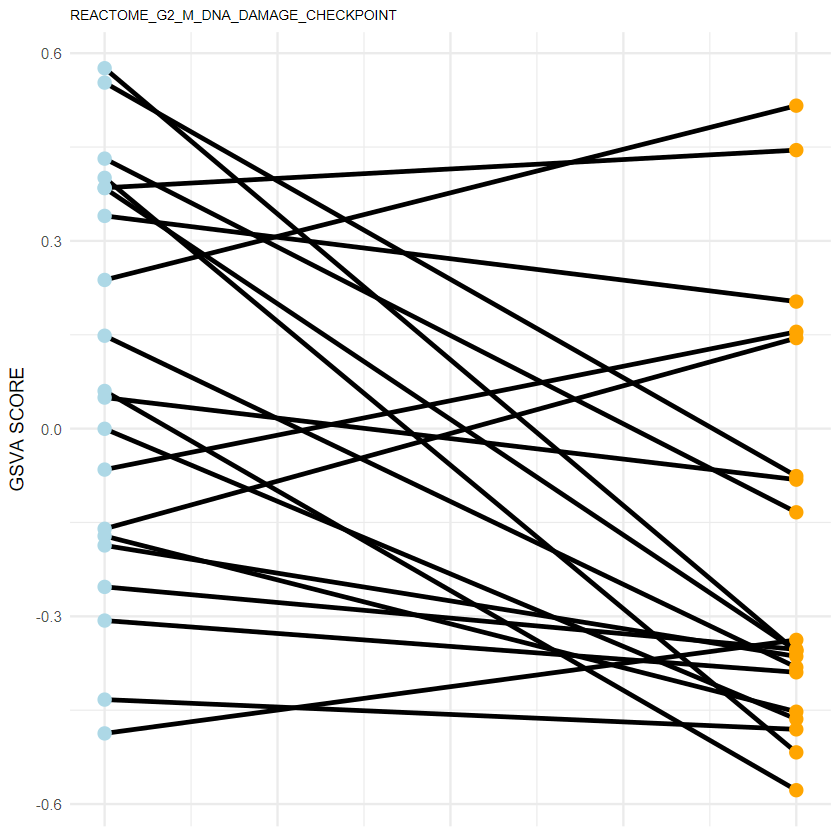

In [70]:
drawline(long_data, path, fold, FALSE)

In [71]:
path2 ="REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION"

In [225]:
pdf(paste0(fold, path2, ".pdf"), width =5 , height=5)
# Create the bar plot for each pathway
coll = ggplot(long_data  %>% filter(Pathway==path2), aes(x = GSVA_Score, y = Patient, fill = Patient_Type)) +
  geom_bar(stat = "identity", position = "dodge") +
  facet_wrap(~ Pathway, scales = "free_y") +  # Facet by pathway
  coord_flip() +  # Flip coordinates to make pathway names readable
  labs(
       x = "GSVA Score",
       y = "Patient") +
  scale_fill_manual(values = c("S" = "orange", "B" = "lightblue"),labels = c("S" = "post", "B" = "pre")) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1 , size = 5))
coll
dev.off()


pdf 
  2

In [73]:
drawline(long_data, path2, fold, TRUE)

pdf 
  2

In [226]:
dna_dam = hallmark_genesets$REACTOME_G2_M_DNA_DAMAGE_CHECKPOINT

In [227]:
ecm =hallmark_genesets$REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION

In [228]:
resdata  %>% filter(Gene %in% dna_dam)  %>% dplyr::select(external_gene_id,Gene,log2FoldChange,padj)  %>%  head

,external_gene_id,Gene,log2FoldChange,padj
,<chr>,<chr>,<dbl>,<dbl>
1,MDC1,ENSG00000137337,0.2507828,0.04051492
2,TP53BP1,ENSG00000067369,0.1952905,0.04241806
3,BRE,ENSG00000158019,0.1426574,0.04384529
4,RNF168,ENSG00000163961,0.1309328,0.16166562
5,HIST4H4,ENSG00000197837,0.3369742,0.27975152
6,WRN,ENSG00000165392,0.1256384,0.40755089


# check correlation among pathways
collagen and DNA damage

In [229]:
# Extract enrichment scores
scores1 <- gsva_es[path, ]
scores2 <- gsva_es[path2, ]

# Pearson correlation (linear relationship)
correlation_pearson <- cor(scores1, scores2, method = "pearson")

# Spearman correlation (monotonic relationship, useful for non-linear trends)
correlation_spearman <- cor(scores1, scores2, method = "spearman")

# Print results
print(paste("Pearson Correlation:", correlation_pearson))
print(paste("Spearman Correlation:", correlation_spearman))

[1] "Pearson Correlation: -0.523231332898372"
[1] "Spearman Correlation: -0.533583489681051"


# heatmap

In [246]:
tpm_log2  %>% head

,X3597_2_97_S,X3597_4_2046_S,X3597_6_2271_S,X3597_8_2472_S,X3597_10_2492_S,X3597_12_2653_S,X3597_14_2661_S,X3597_16_2677_S,X3597_18_2691_S,X3597_20_2739_S,⋯,X3597_21_2789_B,X3597_23_2817_B,X3597_25_2852_B,X3597_27_2976_B,X3597_29_3001_B,X3597_31_3036_B,X3597_33_3065_B,X3597_35_3067_B,X3597_37_3130_B,X3597_39_3161_B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000164949,9.168395,8.849803,9.530329,8.171570,9.176491,11.355208,6.218716,10.932301,11.070078,11.056272,⋯,7.231387,7.699127,8.701686,7.022850,9.111882,8.563593,7.515392,8.975628,8.356567,8.766219
ENSG00000187955,11.238839,8.034663,12.931976,9.965706,10.918069,13.645608,8.627887,12.287379,13.605361,12.961169,⋯,11.175164,10.207283,11.062473,9.260613,12.107005,12.672696,10.983025,11.004422,12.588926,12.969050
ENSG00000102189,9.844588,9.706567,9.739232,9.166664,9.388258,10.130978,9.425613,10.463255,9.924661,9.960543,⋯,8.727662,9.306294,9.148220,9.333254,8.821311,9.417875,9.405110,9.376607,9.421961,9.534922
ENSG00000240184,8.736594,8.325755,9.177136,8.754864,8.692591,9.869641,7.931375,9.618033,10.304547,9.331465,⋯,8.776843,8.187069,7.733864,7.851324,7.962078,9.187522,8.100697,7.767398,9.217337,9.441439
ENSG00000017427,9.997021,7.438176,12.098524,8.250822,9.747292,11.608262,7.525427,10.043887,12.101241,11.165963,⋯,8.356694,8.827084,7.914057,8.049590,10.647960,10.301846,9.012255,9.293855,9.687089,9.138019
ENSG00000142871,11.990669,11.246514,13.633466,11.287044,12.015461,13.862418,10.128610,13.588027,13.944497,13.638009,⋯,12.357544,8.968225,8.907917,10.914096,9.203534,10.226600,9.796577,8.134902,9.888140,11.053380


In [233]:
# Reorder columns by the extracted numeric values without modifying the column names
tpm_log2_sorted <- tpm_log2[, col_ord]

In [247]:
# Reorder columns by the extracted numeric values without modifying the column names
tpm_log2_sorted <- tpm_log2[, c(21:40,1:20)]

In [248]:
tpm_log2_sorted  %>%  head

,X3597_1_97_B,X3597_3_2046_B,X3597_5_2271_B,X3597_7_2472_B,X3597_9_2492_B,X3597_11_2653_B,X3597_13_2661_B,X3597_15_2677_B,X3597_17_2691_B,X3597_19_2739_B,⋯,X3597_22_2789_S,X3597_24_2817_S,X3597_26_2852_S,X3597_28_2976_S,X3597_30_3001_S,X3597_32_3036_S,X3597_34_3065_S,X3597_36_3067_S,X3597_38_3130_S,X3597_40_3161_S
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000164949,6.515084,7.228568,6.538101,7.051898,7.716265,8.825656,4.373750,9.209811,7.824492,8.805613,⋯,9.476721,10.703532,9.720567,11.368445,10.754239,11.499824,11.55768,11.40059,10.34917,9.995081
ENSG00000187955,9.066046,6.288123,9.308665,7.392895,8.248476,11.198182,3.823169,11.729267,11.200845,10.463096,⋯,13.833971,12.696812,12.164783,13.312712,13.396449,14.002049,14.76874,13.99748,14.51737,13.742201
ENSG00000102189,9.193751,8.894377,9.573007,8.629593,8.808824,9.112040,9.158781,9.954423,9.323370,9.229897,⋯,9.029803,10.060481,9.578242,10.359473,9.483440,10.280064,10.11452,10.17206,10.48930,10.060932
ENSG00000240184,7.715139,6.428410,7.264212,7.164892,6.752376,8.537890,7.637615,8.675573,8.427056,7.802629,⋯,10.066012,9.583533,8.035961,9.466143,9.209062,9.717316,10.14299,10.15109,10.56308,9.838454
ENSG00000017427,7.499441,6.493749,8.494144,5.590121,7.000224,10.716774,5.605386,10.003714,9.859657,8.777418,⋯,9.313208,10.290057,10.600339,11.365554,10.973325,12.009541,12.20971,11.75939,11.38519,11.152011
ENSG00000142871,8.681259,9.717057,8.854505,9.990334,10.786504,9.730129,10.659403,10.592357,10.386979,10.528464,⋯,11.806456,13.486261,11.732091,14.147829,13.732454,13.833656,14.69656,13.46781,13.36950,12.728644


In [249]:
ecm_df = tpm_log2_sorted  %>% filter(rownames(tpm_log2_sorted) %in% ecm)

In [250]:
rownames(ecm_df) <- resdata$external_gene_id[match(rownames(ecm_df), resdata$Gene )]

In [251]:
col_df=ecm_df %>%
      rownames_to_column("gene") %>%  # Convert row names to a column
      filter(grepl("^COL|^FN", gene)) %>%  # Use grepl for pattern matching
      column_to_rownames("gene")  # Restore row names

In [252]:
col_df  %>% head

,X3597_1_97_B,X3597_3_2046_B,X3597_5_2271_B,X3597_7_2472_B,X3597_9_2492_B,X3597_11_2653_B,X3597_13_2661_B,X3597_15_2677_B,X3597_17_2691_B,X3597_19_2739_B,⋯,X3597_22_2789_S,X3597_24_2817_S,X3597_26_2852_S,X3597_28_2976_S,X3597_30_3001_S,X3597_32_3036_S,X3597_34_3065_S,X3597_36_3067_S,X3597_38_3130_S,X3597_40_3161_S
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
COL14A1,9.066046,6.288123,9.308665,7.392895,8.248476,11.198182,3.823169,11.72927,11.200845,10.463096,⋯,13.83397,12.696812,12.164783,13.312712,13.396449,14.002049,14.768736,13.997478,14.517372,13.742201
COL6A3,14.029684,11.811775,12.941753,12.773775,13.665139,12.517401,7.942508,14.74037,15.016900,12.832965,⋯,15.74354,14.477185,15.426539,15.597336,15.204293,15.883994,16.711578,15.748134,17.179769,16.063580
COL16A1,10.957969,8.836785,10.798526,10.074265,12.108650,10.205077,8.591573,10.84893,11.211446,9.944459,⋯,13.52720,10.638340,11.436398,12.732904,12.160701,12.160147,13.066326,11.927258,13.817368,12.714332
COL6A1,13.775350,12.689939,12.651335,12.853523,13.754037,12.782136,7.506777,13.83177,14.195183,12.753979,⋯,16.02672,13.853714,14.835208,14.642852,14.240368,15.036044,16.163813,14.727160,16.810106,15.089827
COL6A2,13.779847,12.936042,12.645170,13.111568,14.544867,13.150384,8.026786,14.12679,14.686415,13.144236,⋯,15.97141,14.173266,14.850593,14.878439,14.530621,15.058968,16.218125,15.130933,16.436742,15.128982
COL25A1,1.558462,3.697231,3.306937,3.299353,3.272090,3.492593,0.000000,4.78668,1.223648,3.649197,⋯,6.14939,3.975939,3.051045,4.077244,5.976985,4.282766,4.529461,6.656804,5.351585,3.671563


In [253]:
res <- t(scale(t(col_df)))

In [254]:
res %>%  head

,X3597_1_97_B,X3597_3_2046_B,X3597_5_2271_B,X3597_7_2472_B,X3597_9_2492_B,X3597_11_2653_B,X3597_13_2661_B,X3597_15_2677_B,X3597_17_2691_B,X3597_19_2739_B,⋯,X3597_22_2789_S,X3597_24_2817_S,X3597_26_2852_S,X3597_28_2976_S,X3597_30_3001_S,X3597_32_3036_S,X3597_34_3065_S,X3597_36_3067_S,X3597_38_3130_S,X3597_40_3161_S
COL14A1,-0.9436938,-2.0990934,-0.8427832,-1.6395943,-1.2837393,-0.05689130,-3.124322,0.1639983,-0.05578381,-0.36263003,⋯,1.0393912,0.566421834,0.3451391203,0.8225882,0.85741626,1.1092986,1.428181,1.1073977,1.323633,1.00122225
COL6A3,-0.2543204,-1.4662912,-0.8488178,-0.9406089,-0.4535253,-1.08070382,-3.580642,0.1340294,0.28514110,-0.90826470,⋯,0.6822145,-0.009784728,0.5089875586,0.6023190,0.38754174,0.7589624,1.211194,0.6847223,1.467035,0.85709659
COL16A1,-0.3546100,-1.9299027,-0.4730199,-1.0108907,0.4999406,-0.91374340,-2.112009,-0.4355878,-0.16636600,-1.10729069,⋯,1.5534262,-0.591982060,0.0006939817,0.9635419,0.53859606,0.5381852,1.211157,0.3652307,1.768917,0.94974915
COL6A1,-0.2259647,-0.9159897,-0.9405314,-0.8119946,-0.2395140,-0.85737786,-4.211064,-0.1900991,0.04093398,-0.87527761,⋯,1.2052905,-0.176146479,0.4478149860,0.3255294,0.06965958,0.5754923,1.292445,0.3791262,1.703311,0.60968328
COL6A2,-0.3770882,-0.9571143,-1.1570582,-0.8364591,0.1487820,-0.80977733,-4.331707,-0.1385997,0.24608145,-0.81400342,⋯,1.1293805,-0.106654275,0.3589358998,0.3780770,0.13898954,0.5021720,1.298970,0.5516401,1.449245,0.55029895
COL25A1,-1.4225030,0.1088571,-0.1705938,-0.1760242,-0.1955446,-0.03766379,-2.538362,0.8889027,-1.66222987,0.07446468,⋯,1.8646035,0.308412108,-0.3538126623,0.3809464,1.74116178,0.5281005,0.704734,2.2279125,1.293375,0.09047817


In [ ]:
# Convert ecm_df to a numeric matrix
ecm_matrix <- as.matrix(res)

pdf(paste0(fold,"coll_heat_2.pdf"))
# Create heatmap
Heatmap(ecm_matrix, 
        name = "Expression",
        col = colorRampPalette(c("blue", "white", "red"))(100),
        cluster_rows = TRUE,
        cluster_columns = FALSE,
        row_names_gp = gpar(fontsize = 6),   # Reduce row labels
        column_names_gp = gpar(fontsize = 6) # Reduce column labels
       )
dev.off()

pdf 
  2

In [256]:
dna_df = tpm_log2_sorted  %>% filter(rownames(tpm_log2_sorted) %in% dna_dam)
rownames(dna_df) <- resdata$external_gene_id[match(rownames(dna_df), resdata$Gene )]

In [257]:
res2 = t(scale(t(dna_df)))

In [258]:
# Convert ecm_df to a numeric matrix
dna_matrix <- as.matrix(res2)

pdf(paste0(fold,"dna_df_heat_2.pdf"))
# Create heatmap
Heatmap(dna_matrix, 
        name = "Expression",
        col = colorRampPalette(c("blue", "white", "red"))(100),
        cluster_rows = TRUE,
        cluster_columns = FALSE,
        row_names_gp = gpar(fontsize = 4),   # Reduce row labels
        column_names_gp = gpar(fontsize = 6) # Reduce column labels
       )
dev.off()

pdf 
  2